# $$\text{HW06}$$
$$\text{All units in CGS}$$

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
from scipy.special import gammaln as gln
import emcee
import corner
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln
from matplotlib.pyplot import *
from scipy.optimize import minimize

mpl.rc('font', size=18)
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', serif='palatino')

In [2]:
z = np.array([0, 6, 12, 18]) * 10**(-4)
n = np.array([1880, 940, 530, 305])

r = 0.52 * 10**-4
rho = 0.063 
g = 980 
T = 293 #K

v0_left, v0_right = (1840 - (10*35)), (1840 + (10*35))
kb_left, kb_right =  (1.20-(10*0.034))* 10**-16, (1.20+(10*0.033)) * 10**-16

In [3]:
def log_prior(pars):
    v0, kb = pars
    if v0_left < v0 < v0_right and kb_left < kb < kb_right:
        return 0.0
    return -np.inf

def logLikelihood(pars):
    v_0, kb = pars
    a = (4 * np.pi * r**3 * rho * g)/(3*kb*T)
    sum = 0
    
    for i in range(4):
        t1 = (-v_0 * np.exp(-a*z[i])) 
        t2 = n[i]*np.log(v_0)
        t3 = - (n[i]*a*z[i]) 
        t4 = - gln((n[i]))

        sum += (t1 + t2 + t3 + t4)
        
    return sum

def log_prob(pars):
    lp = log_prior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(pars)

---

# Q1.a)

In [4]:
v0_bar, kb_bar = 1.84E3, 1.20E-16 
pos = [v0_bar, kb_bar] + [1e1, 1e-18] * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 298.72it/s]


<ipython-input-5-2544522ba98c>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


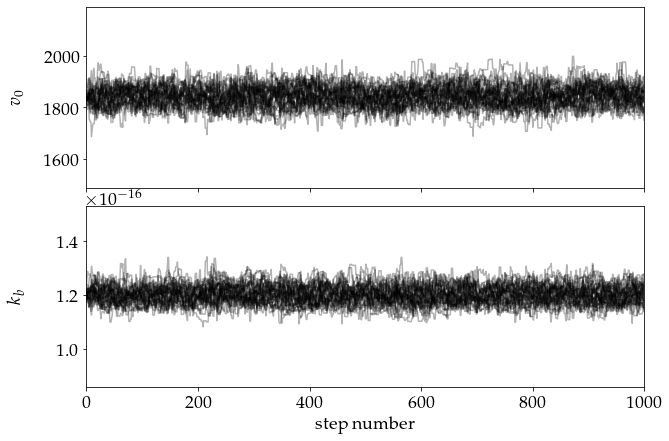

In [5]:
fig, axes = plt.subplots(2,1, figsize=(10, 7), sharex=True,
                         gridspec_kw={'hspace':0.1})
samples = sampler.get_chain()

labels = ['$v_{0}$', '$k_{b}$']
yrange = [(v0_left, v0_right), (kb_left, kb_right)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:1000,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,1000), ylim=yrange[i], ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number')
fig.tight_layout()

---

# Q1.b)

In [6]:
tau = sampler.get_autocorr_time()
print('autocorrelation times: v0 = {:.2f}, kb = {:.2f}'.format(tau[0], tau[1]))

autocorrelation times: v0 = 30.60, kb = 30.76


In [7]:
def acf(x):
    """Compute the autocorrelation of the array.
    """
    data = np.asarray(x)
    n = len(data)
    mean = np.mean(data)
    c0 = np.sum((data - mean)**2) / float(n)
    
    def r(h):
        acfLag = ((data[:n-h] - mean) * (data[h:] - mean)).sum() / float(n) / c0
        return round(acfLag, 3)
    t = np.arange(n)
    return list(map(r,t))

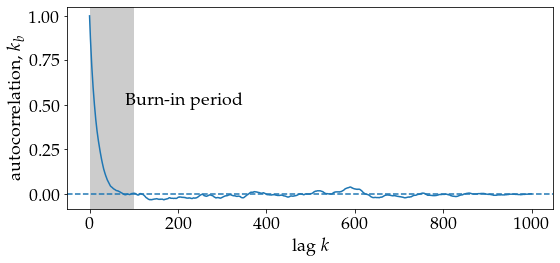

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(acf(samples[:1000,:,1]))
ax.set_xlabel('lag $k$')
ax.set_ylabel(r'autocorrelation, $k_{b}$')
ax.axhline(0, ls="--")
ax.text(80, 0.5, 'Burn-in period')
rect = mpl.patches.Rectangle((0,-2), 100, 30, ec="None", fc="gray", alpha=0.4)
ax.add_patch(rect)
fig.tight_layout();

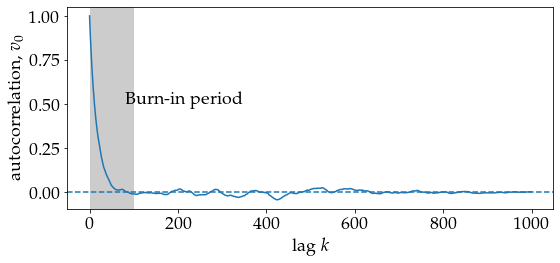

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(acf(samples[:1000,:,0]))
ax.set_xlabel('lag $k$')
ax.set_ylabel(r'autocorrelation, $v_{0}$')
ax.axhline(0, ls="--")
ax.text(80, 0.5, 'Burn-in period')
rect = mpl.patches.Rectangle((0,-2), 100, 30, ec="None", fc="gray", alpha=0.4)
ax.add_patch(rect)
fig.tight_layout();

In [10]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

---

# Q1.c)

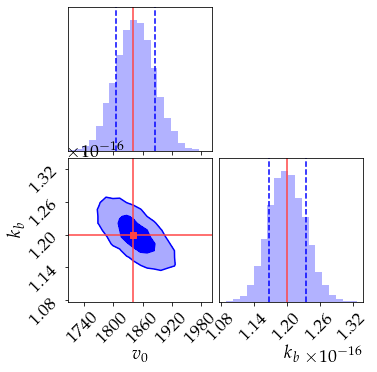

In [11]:
fig = corner.corner(flat_samples, labels=labels,
                 #   range=[(v0_left, v0_right), (kb_left, kb_right)], 
                    bins=21, #smooth=1,
                    truths=[v0_bar, kb_bar], truth_color='#ff4444',
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    color='blue', plot_datapoints=False,
                    fill_contours=True);

### $v_{0}$ and $k_{B}$ are negatively correlated as indicated by the corner plot of $k_{B}$ vs $v_{0}$

### MAP VALUES

In [12]:
v0_hist = plt.hist(np.transpose(flat_samples)[0], bins = 21)
kb_hist = plt.hist(np.transpose(flat_samples)[1], bins = 21)
plt.close()

In [13]:
maxInd_v0 = np.where(v0_hist[0] == max(v0_hist[0]))[0][0]
v0_MAP = v0_hist[1][maxInd_v0]

maxInd_kb = np.where(kb_hist[0] == max(kb_hist[0]))[0][0]
kb_MAP = kb_hist[1][maxInd_kb]

In [14]:
labels = ['v0_MAP', 'kb_MAP']
s = [v0_MAP, kb_MAP]
for i, label in enumerate(labels): 
    x = s[i]
    x16, x84 = np.percentile(flat_samples[:,i], [16,84])
    dlo = x - x16
    dhi = x84 - x
    
    print('{:3s} = {:5.2e} + {:4.2e} - {:4.2e}'.format(label, x, dhi, dlo))
    print('    = ({:5.2e}, {:5.2e})'.format(x16, x84))

v0_MAP = 1.83e+03 + 5.05e+01 - 2.91e+01
    = (1.81e+03, 1.88e+03)
kb_MAP = 1.19e-16 + 4.53e-18 - 2.21e-18
    = (1.17e-16, 1.23e-16)


### $v_{0}$ MAP:  1.83e+03, interval: (1.81e+03, 1.88e+03)
### $k_{B}$ MAP: 1.19e-16, interval: (1.17e-16, 1.23e-16)

---

# Q1.d)

In [15]:
R = np.full(np.shape(flat_samples[:,1]), 8.32e7) # erg/mol/K
NA_list = R/flat_samples[:,1]

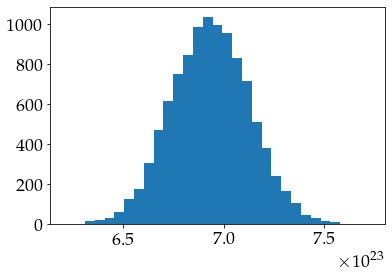

In [16]:
NA_hist = plt.hist(np.transpose(NA_list), bins = 31)

In [17]:
maxInd_NA = np.where(NA_hist[0] == max(NA_hist[0]))[0][0]
NA_MAP = NA_hist[1][maxInd_NA]

In [18]:
label = 'NA_MAP'
x = NA_MAP
x16, x84 = np.percentile(NA_list, [16,84])
dlo = x - x16
dhi = x84 - x

print('{:3s} = {:5.2e} + {:4.2e} - {:4.2e}'.format(label, x, dhi, dlo))
print('    = ({:5.2e}, {:5.2e})'.format(x16, x84))

NA_MAP = 6.90e+23 + 2.32e+22 - 1.57e+22
    = (6.74e+23, 7.13e+23)


### $N_{A}$ MAP:  6.90e+23, interval: (6.74e+23, 7.13e+23)


---

# Q1.e)

In [19]:
def log_prior_v0(v0):
    if v0_left < v0 < v0_right:
        return 0.0
    return -np.inf

In [20]:
def log_prior_kb(kb):
    if kb_left < kb < kb_right:
        return np.log(1/kb * 1/np.log(kb_right/kb_left))
    return -np.inf

In [21]:
def log_prob_jeff(pars):
    v0, kb = pars
    lp_v0 = log_prior_v0(v0)
    lp_kb = log_prior_kb(kb)
    if not np.isfinite(lp_kb) or not np.isfinite(lp_v0):
        return -np.inf
    return lp_v0 + lp_kb + logLikelihood(pars)

In [22]:
v0_bar, kb_bar = 1.84E3, 1.20E-16 
pos = [v0_bar, kb_bar] + [1e1, 1e-18] * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_jeff)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 324.26it/s]


<ipython-input-23-2544522ba98c>:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


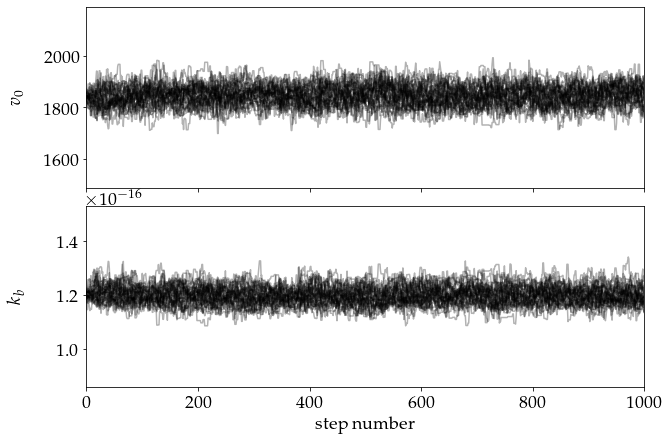

In [23]:
fig, axes = plt.subplots(2,1, figsize=(10, 7), sharex=True,
                         gridspec_kw={'hspace':0.1})
samples = sampler.get_chain()

labels = ['$v_{0}$', '$k_{b}$']
yrange = [(v0_left, v0_right), (kb_left, kb_right)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:1000,:,i], 'k', alpha=0.3)
    ax.set(xlim=(0,1000), ylim=yrange[i], ylabel=labels[i])
    ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number')
fig.tight_layout()

In [24]:
tau = sampler.get_autocorr_time()
print('autocorrelation times: v0 = {:.2f}, kb = {:.2f}'.format(tau[0], tau[1]))
flat_samples_jeff = sampler.get_chain(discard=100, thin=15, flat=True)

autocorrelation times: v0 = 29.58, kb = 29.27


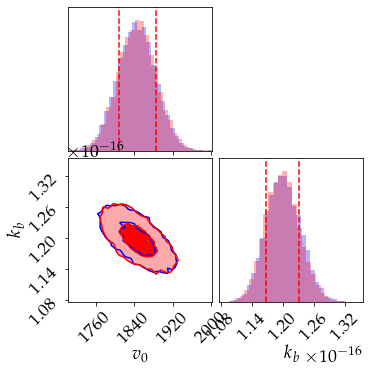

In [25]:
fig = corner.corner(flat_samples, labels=labels,
#                    range=[(3.2,5.8), (-1.3,-0.7), (-1.4,0)],
                    bins=30, #smooth=1,
#                     truths=[a_true, b_true, np.log(f_true)], truth_color='#ff4444',
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), #quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3, 'density':True},
                    color='blue', plot_datapoints=False,
                    fill_contours=True);

corner.corner(flat_samples_jeff, labels=labels, fig=fig,
#                    range=[(3.2,5.8), (-1.3,-0.7), (-1.4,0)], 
                    bins=30, #smooth=1,
#                     truths=[a_true, b_true, np.log(f_true)], truth_color='#ff4444',
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)), quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3, 'density':True},
                    color='r', plot_datapoints=False,
                    fill_contours=True);

### From the overlay of the previous corner plot and the new corner plot we can see that there is no significant different between the two.

---

# Q1.f)

In [26]:
stdev = dlo
CODATA_val = 6.022E23 

n_sigma = (NA_MAP - CODATA_val)/stdev
print('Perrin\'s value is {:.2f} sigma away from CODATA value'.format(n_sigma))

Perrin's value is 5.55 sigma away from CODATA value


### Our estimate for $N_{A}$ is bigger than that found in CODATA standard value by 5.55 $\sigma$. It is a statistically significant difference. This could most likely be the volume used to calculate E. The limiting factor that only the particles in a layer approximately 1 µm thick were in focus; particles outside this layer were not visible could have resulted in undercounting in some way which would affect all of our analysis and as a result give us a larger value of $N_{A}$